In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor
from scipy.cluster.vq import kmeans, vq, whiten
from scipy.spatial.distance import cdist
from datetime import datetime

In [3]:
df_prediction_data = pd.read_csv("./meter_data/Office_Amelia.csv", parse_dates=True, index_col='timestamp')
df_prediction_data

,Office_Amelia
timestamp,
2015-01-01 00:00:00,3.96
2015-01-01 01:00:00,4.44
2015-01-01 02:00:00,4.82
2015-01-01 03:00:00,4.28
2015-01-01 04:00:00,18.79
...,...
2015-12-31 19:00:00,5.20
2015-12-31 20:00:00,3.76
2015-12-31 21:00:00,0.84


<Axes: xlabel='timestamp'>

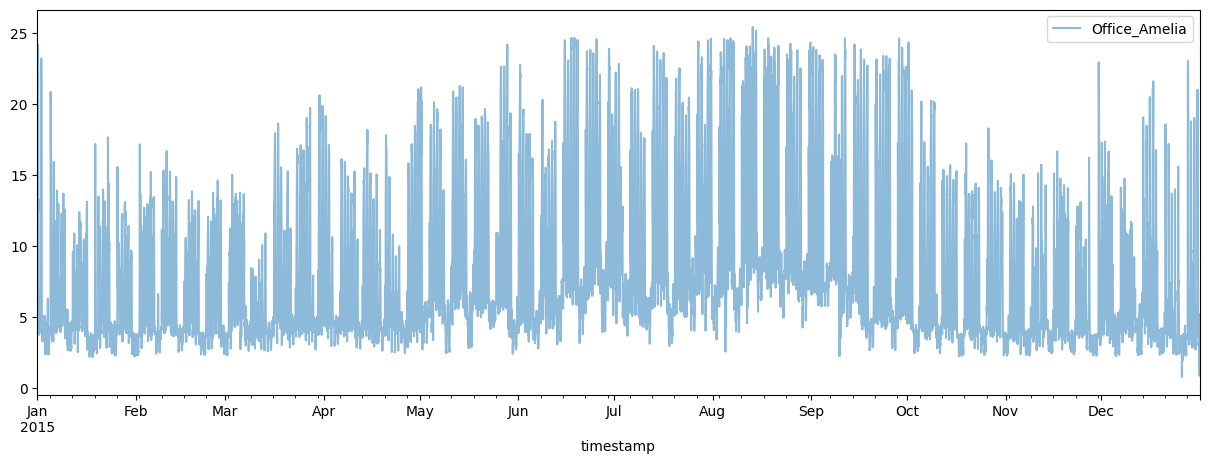

In [4]:
df_prediction_data.plot(alpha=0.5, figsize=(15, 5))

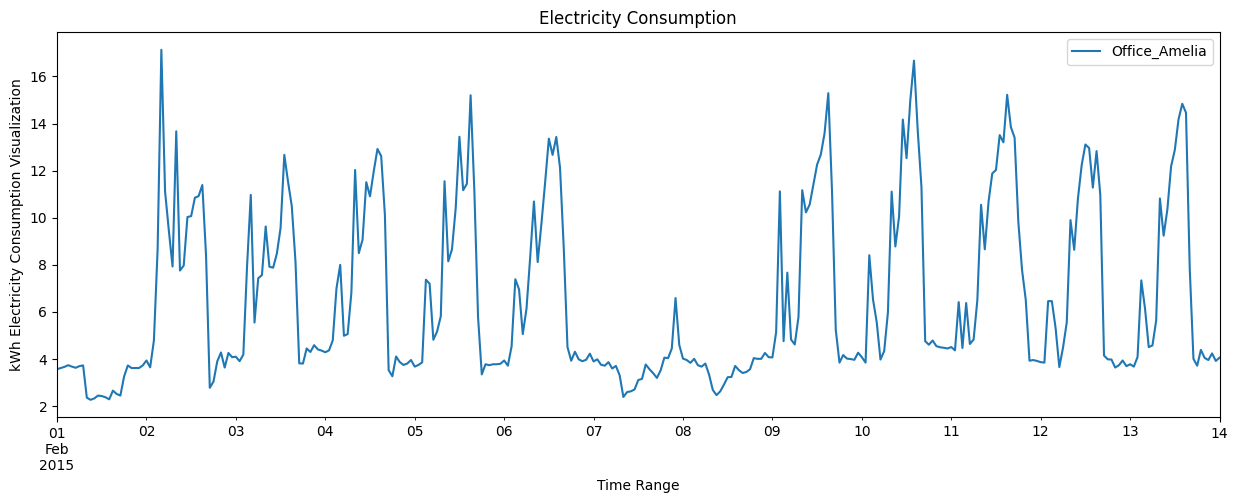

In [5]:
df_prediction_data.truncate(before='2015-02-01', after='2015-02-14').plot(figsize=(15,5))
plt.title("Electricity Consumption")
plt.xlabel("Time Range")
plt.ylabel("kWh Electricity Consumption Visualization");

In [6]:
weather_data = pd.read_csv("./weather_data/weather2.csv", index_col='timestamp', parse_dates=True)
weather_data.head()

,Conditions,DateUTC<br />,Dew PointC,Events,Gust SpeedKm/h,Humidity,Precipitationmm,Sea Level PressurehPa,TemperatureC,TimeEDT,TimeEST,VisibilityKm,Wind Direction,Wind SpeedKm/h,WindDirDegrees,timestamp.1
timestamp,,,,,,,,,,,,,,,,
2015-01-01 00:56:00,Overcast,2015-01-01 05:56:00<br />,-15.0,NaN,-,54.0,NaN,1017.4,-7.2,NaN,12:56 AM,16.1,SW,18.5,230,2015-01-01 00:56:00
2015-01-01 01:56:00,Overcast,2015-01-01 06:56:00<br />,-14.4,NaN,-,55.0,NaN,1017.2,-6.6,NaN,1:56 AM,16.1,WSW,14.8,240,2015-01-01 01:56:00
2015-01-01 02:56:00,Overcast,2015-01-01 07:56:00<br />,-14.4,NaN,-,55.0,NaN,1016.9,-6.6,NaN,2:56 AM,16.1,SW,14.8,220,2015-01-01 02:56:00
2015-01-01 03:56:00,Overcast,2015-01-01 08:56:00<br />,-14.4,NaN,-,55.0,NaN,1017.2,-6.6,NaN,3:56 AM,16.1,SW,18.5,220,2015-01-01 03:56:00
2015-01-01 04:56:00,Overcast,2015-01-01 09:56:00<br />,-14.4,NaN,-,55.0,NaN,1017.2,-6.6,NaN,4:56 AM,16.1,SSW,14.8,210,2015-01-01 04:56:00


In [7]:
weather_houly = weather_data.resample('h').mean(numeric_only=True)
weather_houly_nooutlier = weather_houly[weather_houly > -40]
weather_houly_nooutlier_nogaps = weather_houly_nooutlier.ffill()

<Axes: xlabel='timestamp'>

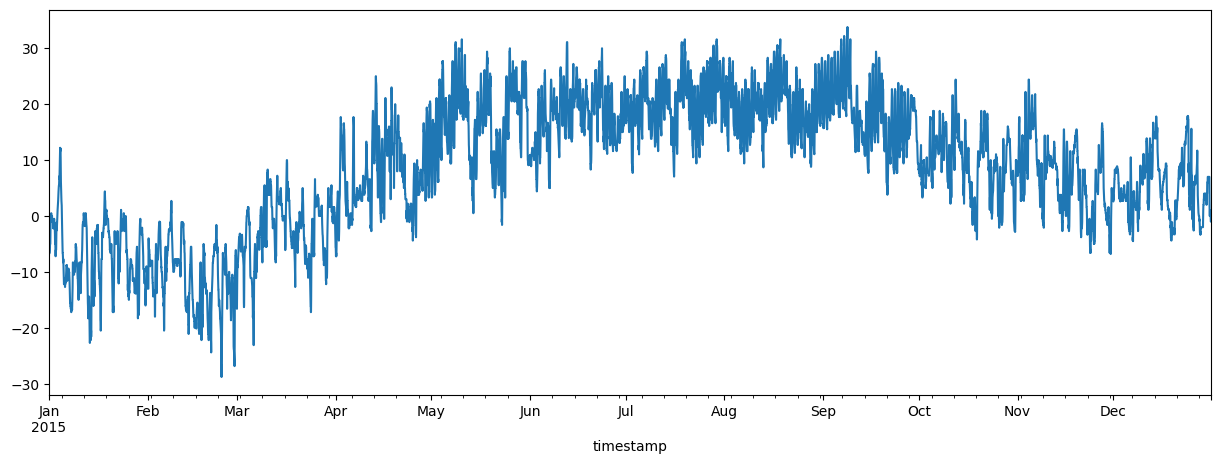

In [8]:
temperature = weather_houly_nooutlier_nogaps['TemperatureC']
temperature.plot(figsize=(15, 5))

### Create Train and Test Datasets for Supervsed Learning

we will use 3 months of data from April, May, and June to prediction July.

In [9]:
training_months = [4,5,6]
test_months = [7]

In [10]:
trainingdata = df_prediction_data[df_prediction_data.index.month.isin(training_months)]
testdata = df_prediction_data[df_prediction_data.index.month.isin(test_months)]

In [11]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2184 entries, 2015-04-01 00:00:00 to 2015-06-30 23:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Office_Amelia  2184 non-null   float64
dtypes: float64(1)
memory usage: 34.1 KB


In [12]:
testdata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2015-07-01 00:00:00 to 2015-07-31 23:00:00
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Office_Amelia  744 non-null    float64
dtypes: float64(1)
memory usage: 11.6 KB


### Encoding Categorical Columns

In [13]:
train_features = pd.concat([pd.get_dummies(trainingdata.index.hour), 
                                     pd.get_dummies(trainingdata.index.dayofweek), 
                                     pd.DataFrame(temperature[temperature.index.month.isin(training_months)].values)], axis=1).dropna()

In [14]:
train_features.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,0,1,2,3,4,5,6,0
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,-5.5
1,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,-6.1
2,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,-7.2
3,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,-6.6
4,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,-7.2


In [19]:
test_features = np.array(pd.concat([pd.get_dummies(testdata.index.hour),
                                    pd.get_dummies(testdata.index.dayofweek),
                                    pd.DataFrame(temperature[temperature.index.month.isin(test_months)].values)], axis=1).dropna())

In [20]:
test_features

array([[True, False, False, ..., False, False, 17.7],
       [False, True, False, ..., False, False, 17.2],
       [False, False, True, ..., False, False, 16.6],
       ...,
       [False, False, False, ..., False, False, 17.7],
       [False, False, False, ..., False, False, 18.3],
       [False, False, False, ..., False, False, 17.7]], dtype=object)

In [21]:
print(train_features.shape, trainingdata.shape)

(2184, 32) (2184, 1)


In [22]:
model = KNeighborsRegressor()
model.fit(np.array(train_features), np.array(trainingdata.values))

KNeighborsRegressor()

In [23]:
# predictions
preds = model.predict(test_features)

In [24]:
predicted_vs_actual = pd.concat([testdata, pd.DataFrame(preds, index=testdata.index)], axis=1)

In [25]:
predicted_vs_actual = predicted_vs_actual.rename(columns={"Office_Amelia":"Actual", 0: "Predicted"})

<Axes: xlabel='timestamp'>

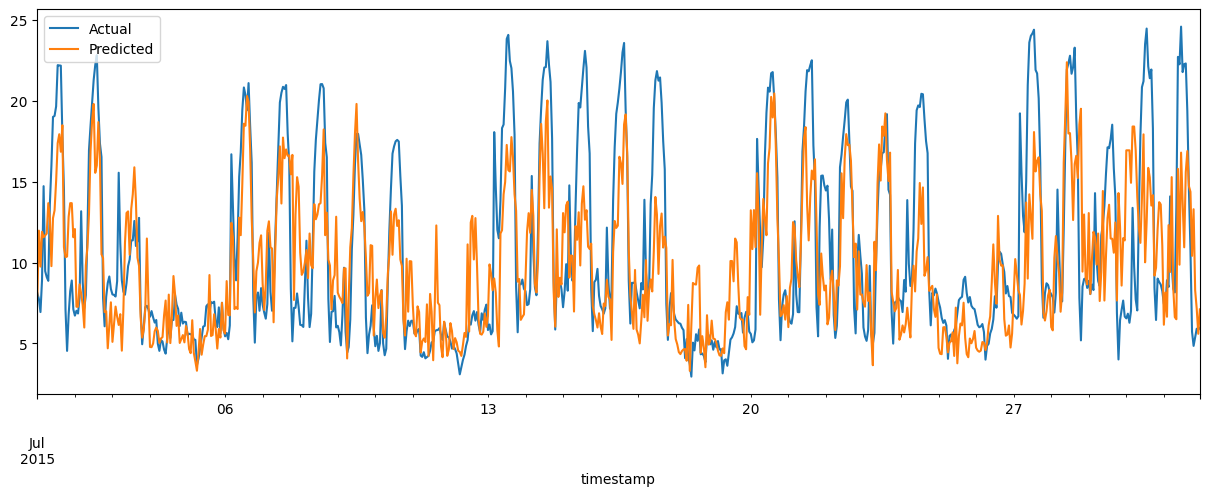

In [26]:
predicted_vs_actual.plot(figsize=(15, 5))

In [27]:
trainingdata = trainingdata.rename(columns={"Office_Amelia":"Actual"})
trainingdata.head()

,Actual
timestamp,
2015-04-01 00:00:00,4.63
2015-04-01 01:00:00,4.61
2015-04-01 02:00:00,4.39
2015-04-01 03:00:00,7.52
2015-04-01 04:00:00,6.06


In [28]:
predicted_vs_actual_training = pd.concat([trainingdata, predicted_vs_actual], sort=True) 

<Axes: xlabel='timestamp'>

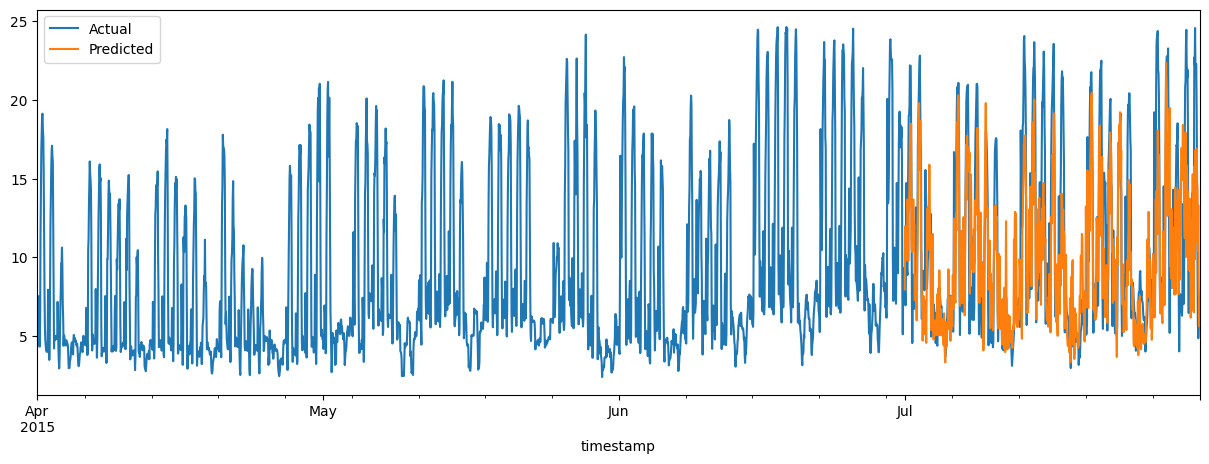

In [29]:
predicted_vs_actual_training.plot(figsize=(15, 5))

### Evaluation the model

##### MAPE VS MSE
https://stats.stackexchange.com/questions/11636/the-difference-between-mse-and-mape#:~:text=MSE%20is%20scale%2Ddependent%2C%20MAPE,when%20percentages%20make%20no%20sense.

In [30]:
error = abs(predicted_vs_actual['Actual'] - predicted_vs_actual['Predicted'])
MAPE = sklearn.metrics.mean_absolute_percentage_error(predicted_vs_actual['Actual'], predicted_vs_actual['Predicted'])
MAPE * 100

30.66987299306262